<a href="https://colab.research.google.com/github/ccomkhj/Leaf_Disease-Classification/blob/master/Leaf_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator
import json
from sklearn.model_selection import train_test_split
from collections import Counter

In [17]:
User = 'HJ'
if User == 'HJ':
    work_dir = "/content/drive/My Drive/ML/Leaf Deases/"
    path = "/content/drive/My Drive/ML/Leaf Deases/"
    train_path = path+'train_images/'
    TEST_DIR = path + 'test_images/'

In [4]:
df_train = pd.read_csv(path+'train.csv')
data = pd.read_csv(work_dir + 'train.csv')

In [5]:
df_train['label']=df_train['label'].astype(str)
# Importing the json file with labels
f = open(work_dir + 'label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}

In [6]:
# Defining the working dataset
data['class_name'] = data.label.map(real_labels)

# Spliting the data
train,val = train_test_split(data, test_size = 0.05, random_state = 42, stratify = data['class_name'])
print(Counter(df_train['label']))

Counter({'3': 13158, '4': 2577, '2': 2386, '1': 2189, '0': 1087})


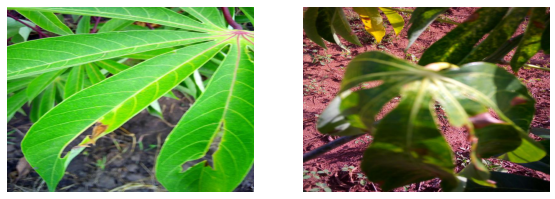

In [9]:
df0 = df_train[df_train["label"] == "0"]
files = df0["image_id"].sample(2).tolist()
# files = ['1000015157.jpg','1000201771.jpg','100042118.jpg',]

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(train_path + file)
    plt.subplot(1, 3, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

Create Dataset

In [21]:
IMG_SIZE = 380
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 12

datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

train_set = datagen_train.flow_from_dataframe(train,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

val_set = datagen_val.flow_from_dataframe(val,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 20327 validated image filenames belonging to 5 classes.
Found 1070 validated image filenames belonging to 5 classes.


Create Model

In [25]:
#%% MODEL CREATION 

from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB4



def create_model():
    
    model = Sequential()
    # initialize the model with input shape as (224,224,3)
    model.add(EfficientNetB4(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet',
                             drop_connect_rate=0.6))
    #for layer in model.layers[:-40]:  # Training just part of the architecture do not optimize the performance
    #    layer.trainable = False
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(n_CLASS, activation = 'softmax'))
    
    return model

leaf_model = create_model()
leaf_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 12, 12, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1792)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                57376     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 165       
Total params: 17,731,364
Trainable params: 17,606,157
Non-trainable params: 125,207
____________________________________

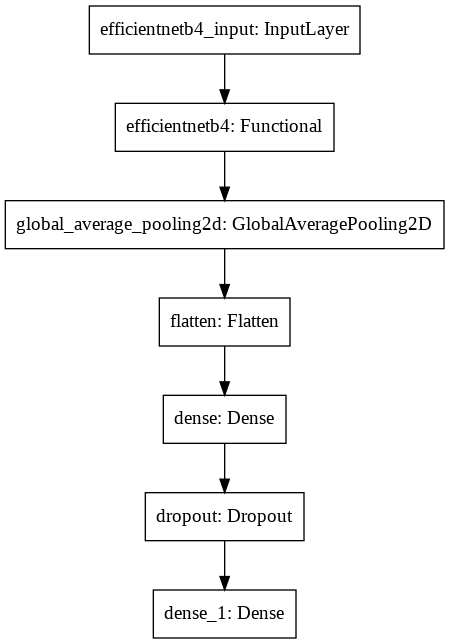

In [12]:
keras.utils.plot_model(leaf_model)

In [24]:
EPOCHS = 2
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size

Compile Model

In [14]:
#%% FITTING THE MODEL

def Model_fit():
    
    #leaf_model = None
    
    leaf_model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' )
    
    leaf_model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['categorical_accuracy']) #'acc'
    
    # Stop training when the val_loss has stopped decreasing for 3 epochs.
    es = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("Cassava_best_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    
    history = leaf_model.fit(train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[es, checkpoint_cb, reduce_lr])
    
    leaf_model.save('Cassava_model'+'.h5')  
    
    return history

In [23]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
results = Model_fit()

Epoch 1/2
 831/1693 [=============>................] - ETA: 1:12:43 - loss: 1.0829 - categorical_accuracy: 0.6035

In [ ]:
#%% CHECKING THE METRIC

print('Train_Cat-Acc: ', max(results.history['categorical_accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_categorical_accuracy']))

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['categorical_accuracy'],results.history['val_categorical_accuracy'],
               results.history['loss'],results.history['val_loss'])

Evaluation

In [ ]:
import keras

final_model = keras.models.load_model('Cassava_best_model.h5')

In [ ]:

test_images = os.listdir(TEST_DIR)
predictions = []

for image in test_images:
    img = Image.open(TEST_DIR + image)
    img = img.resize(size)
    img = np.expand_dims(img, axis=0)
    predictions.extend(final_model.predict(img).argmax(axis = 1))

Submission

In [ ]:
sub = pd.DataFrame({'image_id': test_images, 'label': predictions})
display(sub)
sub.to_csv('submission.csv', index = False)